# ICN Programming Course

<p align="center">
    <img width="500" alt="image" src="https://github.com/Lenakeiz/ICN_Programming_Course/blob/main/Images/cog_neuro_logo_blue_png_0.png?raw=true">
</p>

---

# **WEEK 5** - A working example - calculating the firing rate map from a grid cell

In this example, we will bring together everything we have learned so far about:
- Reading and working with data files,  
- Using classes to organize code

Plus we are going to see how to do basic plotting using a very common package/module `matplotlib`.  

We will use a **real dataset** from a neuroscience experiment that recorded the activity of **grid cells** in the medial entorhinal cortex of a rodent while it moved freely in space.

---

### What are Grid Cells?

Grid cells are neurons that fire in a spatially periodic pattern when an animal navigates through an environment.  
Their firing fields form a striking hexagonal grid across space — each cell activates at multiple evenly spaced locations in the environment while the rat is moving for foraging.

The image below shows examples of grid cell activity, where brighter spots correspond to locations in which the neuron fired more often:

<p align="center">
    <img width="500" alt="image" src="https://github.com/Lenakeiz/ICN_Programming_Course/blob/main/week_5/images/grid_cell.png?raw=true">
</p>

For this tutorial we are going to use a recent dataset from the <a href="https://www.nature.com/articles/s41586-021-04268-7" target="_blank">Gardner et al., 2022</a> paper, which demonstrated grid cells resides in a toroidal manifold.

For the purpose of this example a single grid cells from the dataset as been extracted and you can find the data inside `week_5/data/grid_example` folder.

The overall goal is not to fully reproduce the paper’s analysis but to illustrate a *complete workflow*:
1. **Load the data** (animal’s position, time, and spike times).  
2. **Encapsulate computations in a class** called `GridCellAnalysis`.  
3. **Compute firing rate maps** showing where the neuron fired more often.  
4. **Plot both the trajectory and the resulting spatial maps.**

## Load the data

The first step in any analysis is to **load the data** into Python.

In this example, we have two separate files that represent two types of recordings from a single grid cell experiment:

1. **`behavioural_data.csv`** — contains the *behavioural tracking data* of the rat moving inside an open box.  
   - Each row corresponds to one time point in the recording.  
   - The main columns are:
     - `x`: the x-position of the rat in the arena (in meters)
     - `y`: the y-position of the rat in the arena (in meters)
     - `t`: the time at which the position was recorded (in seconds)
   - Together, these three columns describe the rat’s *trajectory* over time.

2. **`spike_times.txt`** — contains the *spike train* for a single neuron.  
   - Each line is one timestamp (in seconds) when that neuron fired an action potential.  
   - These spike times are typically extracted from electrophysiological recordings.

We will read both files into **NumPy arrays**, which makes it easy to perform numerical operations later (e.g. filtering, binning, rate calculations).

### Inspecting the Data Files

Before writing any code, it’s always a good idea to take a quick look at the raw files.  
You can open them in any text editor or use the command line:

```
head behavioural_data.csv
head spike_times.txt
```

In [14]:
import csv
import numpy as np
import os


data_dir = "data"
subdir = "grid_cell_example"

behave_data_path = os.path.join(data_dir, subdir, "behavioural_data.csv")
spike_file = os.path.join(data_dir, subdir, "spike_times.txt")

# Create empty arrays to store values
x_pos = np.array([])
y_pos = np.array([])
time = np.array([])

# Load behave data
data = np.genfromtxt(behave_data_path, delimiter=",", names=True)
x_pos = data["x"]
y_pos = data["y"]
beh_time = data["t"]

spike_times = np.loadtxt(spike_file)

# Print confirmation
print("x_pos shape:", x_pos.shape)
print("y_pos shape:", y_pos.shape)
print("time shape:", time.shape)
print("spike_times shape:", spike_times.shape)

x_pos shape: (339699,)
y_pos shape: (339699,)
time shape: (0,)
spike_times shape: (6859,)


### Building the GridCellAnalysisClass - `__init__`

Now that we have loaded the data into NumPy arrays, we will wrap the analysis into a small **class**.
Why a class? Because it lets us:
- keep **data** (positions, time, spikes) in attributes and **methods** (plotting, computing maps) together
- make analysis **re-usable**, we can create multiple instances of the class


A grid-cell analysis class should work on the following streams of information and provide:
1. **Animal trajectory**: `x(t)`, `y(t)` sampled at regular(ish) intervals → arrays `x`, `y`, `t`.
2. **Spike train**: timestamps of spikes → array `spike_times`.
3. **Spatial binning**: for conducting our analysis we need a way to work with a streams of position data (x and y coordinates over time) and discrete events (spike times). To relate the continuous movement to the discrete spiking activity, the continuous space is divided into discrete spatial bins. This allows for counting how many times the animal visited each spatial bin and how many spikes occurred within each bin. Therefore we are going to introduce a variable, provided as an input to the class constructor, to deal with the dimension of this binning.

#### The `__init__` function

In [ ]:
import numpy as np

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")


In [ ]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

print(f"First recorded position: x : {grid_analysis_single_neuron.x[0]}, y : {grid_analysis_single_neuron.y[0]}")

## Plotting the Data: Trajectory and Spike Times

Once we have created an instance of our `GridCellAnalysis` class,  
the next step is to **visualize the basic attributes** - the animal’s trajectory and the neuron’s spike times.  
These simple plots help us check that everything looks correct before moving on to more complex analyses.

### Introducing `matplotlib`

We’ll use **Matplotlib**, Python’s main plotting library.  
Matplotlib is designed to work a lot like MATLAB’s plotting interface:
- You create **figures** and **axes** where plots are drawn.  
- You use simple commands like `plot()`, `scatter()`, and `imshow()` to display data.  
- You can label axes, add titles, and control colours or line styles.

#### Matplotlib the `plot()` function

The `matplotlib.pyplot.plot()` function is a versatile tool used to draw points (markers) and lines in a 2D plot. It's one of the most fundamental functions in Matplotlib for visualizing data.

Here's a breakdown of its common usage and parameters:

**Basic Usage:**

-   `plt.plot(y)`: Plots the values in sequence `y` against their indices. For example, if `y` is `[1, 3, 2, 4]`, it will plot points at (0, 1), (1, 3), (2, 2), and (3, 4) and connect them with lines.
-   `plt.plot(x, y)`: Plots the values in sequence `y` against the corresponding values in sequence `x`. `x` and `y` should have the same length.
-   `plt.plot(x, y, format_string)`: Plots `y` versus `x` with a specified format string that controls the color, marker, and line style.

**Format String:**

The format string is a shorthand way to define the appearance of the plot. It's a combination of characters for:

-   **Color:** e.g., 'b' (blue), 'g' (green), 'r' (red), 'c' (cyan), 'm' (magenta), 'y' (yellow), 'k' (black), 'w' (white)
-   **Marker:** e.g., '.' (point), 'o' (circle), 'v' (triangle_down), '^' (triangle_up), 's' (square), '*' (star), '+' (plus), 'x' (x)
-   **Line Style:** e.g., '-' (solid line), '--' (dashed line), '-.' (dash-dot line), ':' (dotted line)

You can combine these characters in any order. For example:

-   `'ro-'`: red circles connected by a solid line
-   `'b.'`: blue points
-   `'k--'`: black dashed line


In [19]:
import numpy as np
import matplotlib.pyplot as plt

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")

    def plot_trajectory(self):
        """
        Plot the 2D trajectory of the animal (x vs y).
        """
        plt.figure(figsize=(6, 6))
        plt.plot(self.x, self.y, color='k', alpha=0.6)
        plt.plot(self.x[0], self.y[0], 'go', label='start')
        plt.plot(self.x[-1], self.y[-1], 'ro', label='end')

        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.title("Animal Trajectory")
        plt.legend()
        plt.axis("equal")
        plt.show()


In [ ]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

grid_analysis_single_neuron.plot_trajectory()

#### Matplotlib `eventplot` function

To visualize discrete events over time we can use the `eventplot()` function in **Matplotlib**.

An *event* can be anything that happens at specific time points - for example:
- neural spikes (when a neuron fires),
- stimulus onsets,
- button presses,
- trial start or end times,
- or any other timestamped occurrences.

`eventplot()` takes one or more lists or arrays of event times and draws **vertical tick marks** at those time points.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")

    def plot_trajectory(self):
        """
        Plot the 2D trajectory of the animal (x vs y).
        """
        plt.figure(figsize=(6, 6))
        plt.plot(self.x, self.y, color='k', alpha=0.6)
        plt.plot(self.x[0], self.y[0], 'go', label='start')
        plt.plot(self.x[-1], self.y[-1], 'ro', label='end')

        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.title("Animal Trajectory")
        plt.legend()
        plt.axis("equal")
        plt.show()

    def plot_spike_events(self):
        """
        Plot the spike times as an event raster.
        """
        plt.figure(figsize=(8, 3))
        plt.eventplot(self.spike_times, color="black", lineoffsets=0, linelengths=1)
        plt.xlabel("Time (s)")
        plt.title("Spike Times")
        plt.tight_layout()
        plt.show()

x - min: -0.72621924, max: 0.7381525, shape: (339699,)
y - min: -0.72309124, max: 0.73905075, shape: (339699,)
t - min: 27826.01, max: 31222.99, shape: (339699,)
spike_times - min: 27826.754033333335, max: 31215.780933333335, shape: (6859,)


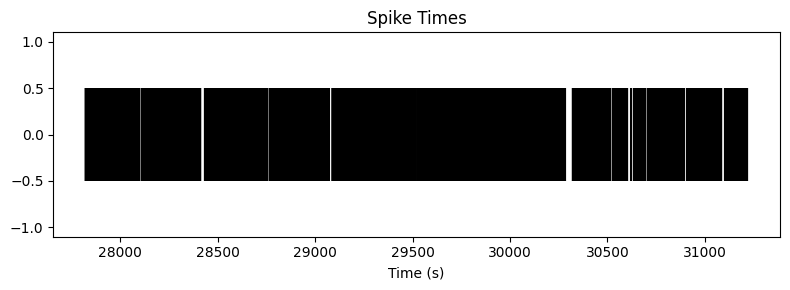

In [22]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

grid_analysis_single_neuron.plot_spike_events()

## Computing the firing rate map

To calculate the firing rate map of our neuron we need to calculate the average firing rate of the neuron in different spatial locations within the environment.

It achieves this by dividing the number of spikes that occurred in each spatial bin by the amount of time the animal spent in that bin (dwell time).

Once we have binned our space we can compute the following:

$$
\text{Firing rate} = \frac{\text{Number of spikes in that location}}{\text{Time spent in that location}}
$$

This gives us a map where:
- Bright areas = locations where the neuron fired more often,
- Dark areas = locations where it fired little or not at all.

### Binnnig the space
We divide the space into small squares using `np.arange()`.  
The smaller the bin size, the more detailed (but noisier) the map.

### Calculating the time occupancy
we use `np.histogram2d()` to count how many samples fall in each spatial bin. 
The output of this function is an **n-D array** that shows how many samples fell into each bin. 
Because each sample corresponds to a short time step, this gives us how long the rat spent in each area.  
This is called the `dwell_time`.

### Calculating the counts of spiking for each bin
We need to know *where the animal was* at each spike time.  
We find the position sample that occurred just after each spike using **numpy** `self.t.searchsorted()`.  
This gives the index of the position sample that corresponds to each spike.  
We then count how many spikes occurred in each spatial bin and save it in a parameter variable called `spike_counts`.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")

    def plot_trajectory(self):
        """
        Plot the 2D trajectory of the animal (x vs y).
        """
        plt.figure(figsize=(6, 6))
        plt.plot(self.x, self.y, color='k', alpha=0.6)
        plt.plot(self.x[0], self.y[0], 'go', label='start')
        plt.plot(self.x[-1], self.y[-1], 'ro', label='end')

        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.title("Animal Trajectory")
        plt.legend()
        plt.axis("equal")
        plt.show()

    def plot_spike_events(self):
        """
        Plot the spike times as an event raster.
        """
        plt.figure(figsize=(8, 3))
        plt.eventplot(self.spike_times, color="black", lineoffsets=0, linelengths=1)
        plt.xlabel("Time (s)")
        plt.title("Spike Times")
        plt.tight_layout()
        plt.show()

    def compute_firing_rate_map(self):
            
            # Compute bins using provided bin_size
            x_bins = np.arange(np.min(self.x) - self.bin_size * 0.5, np.max(self.x) + self.bin_size * 0.5, self.bin_size)
            y_bins = np.arange(np.min(self.y) - self.bin_size * 0.5, np.max(self.y) + self.bin_size * 0.5, self.bin_size)

            # Compute dwell time
            self.dwell_time, _, _ = np.histogram2d(self.x, self.y, bins=(x_bins, y_bins))

            # Compute spike counts
            self.spike_counts, _, _ = np.histogram2d(self.x[self.t.searchsorted(self.spike_times, side='right')],
                                                self.y[self.t.searchsorted(self.spike_times, side='right')],
                                                bins=(x_bins, y_bins))

            # Handle zero dwell times (avoid division by zero)
            self.dwell_time[self.dwell_time == 0] = min(self.dwell_time[self.dwell_time != 0], default=1) # Added default=1

            # Compute unsmoothed firing rate map
            self.unsmoothed_firing_rate_map = self.spike_counts / self.dwell_time

In [33]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

grid_analysis_single_neuron.compute_firing_rate_map()

x - min: -0.72621924, max: 0.7381525, shape: (339699,)
y - min: -0.72309124, max: 0.73905075, shape: (339699,)
t - min: 27826.01, max: 31222.99, shape: (339699,)
spike_times - min: 27826.754033333335, max: 31215.780933333335, shape: (6859,)


## Plotting the Firing Rate Maps

Once we have computed the firing rate map the next step is to visualize them.  
A plot helps us *see* where in space the neuron was more active, with colour intensity representing firing rate.

### Matplotlib `imshow` function

We use Matplotlib’s `imshow()` function to display a **2D array** (like an image).
It takes a 2D array (like a matrix or image) and displays it as a **colour-coded image**,  
where the colour of each pixel represents the numerical value at that point. 
In this case, the 2D array is our **firing rate map**,  
where each element represents the neuron’s firing rate in the binned area of the environment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")

    def plot_trajectory(self):
        """
        Plot the 2D trajectory of the animal (x vs y).
        """
        plt.figure(figsize=(6, 6))
        plt.plot(self.x, self.y, color='k', alpha=0.6)
        plt.plot(self.x[0], self.y[0], 'go', label='start')
        plt.plot(self.x[-1], self.y[-1], 'ro', label='end')

        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.title("Animal Trajectory")
        plt.legend()
        plt.axis("equal")
        plt.show()

    def plot_spike_events(self):
        """
        Plot the spike times as an event raster.
        """
        plt.figure(figsize=(8, 3))
        plt.eventplot(self.spike_times, color="black", lineoffsets=0, linelengths=1)
        plt.xlabel("Time (s)")
        plt.title("Spike Times")
        plt.tight_layout()
        plt.show()

    def compute_firing_rate_map(self):
            
            # Compute bins using provided bin_size
            x_bins = np.arange(np.min(self.x) - self.bin_size * 0.5, np.max(self.x) + self.bin_size * 0.5, self.bin_size)
            y_bins = np.arange(np.min(self.y) - self.bin_size * 0.5, np.max(self.y) + self.bin_size * 0.5, self.bin_size)

            # Compute dwell time
            self.dwell_time, _, _ = np.histogram2d(self.x, self.y, bins=(x_bins, y_bins))

            # Compute spike counts
            self.spike_counts, _, _ = np.histogram2d(self.x[self.t.searchsorted(self.spike_times, side='right')],
                                                self.y[self.t.searchsorted(self.spike_times, side='right')],
                                                bins=(x_bins, y_bins))

            # Handle zero dwell times (avoid division by zero)
            self.dwell_time[self.dwell_time == 0] = min(self.dwell_time[self.dwell_time != 0], default=1) # Added default=1

            # Compute unsmoothed firing rate map
            self.unsmoothed_firing_rate_map = self.spike_counts / self.dwell_time

    def plot_unsmoothed_rate_map(self):
            """
            Plot the firing rate map
            """

            if self.unsmoothed_firing_rate_map is None:
                raise ValueError("You must compute the firing rate map first using compute_firing_rate_map().")

            plt.figure(figsize=(6, 6))

            im = plt.imshow(
                self.unsmoothed_firing_rate_map,
                origin='lower',
                cmap='jet',
                interpolation='nearest'
            )

            plt.title('Unsmoothed Firing Rate Map')
            plt.xlabel('x position (bins)')
            plt.ylabel('y position (bins)')
            plt.colorbar(im, label='Firing rate (spikes / dwell time)')
            plt.tight_layout()
            plt.show()

x - min: -0.72621924, max: 0.7381525, shape: (339699,)
y - min: -0.72309124, max: 0.73905075, shape: (339699,)
t - min: 27826.01, max: 31222.99, shape: (339699,)
spike_times - min: 27826.754033333335, max: 31215.780933333335, shape: (6859,)


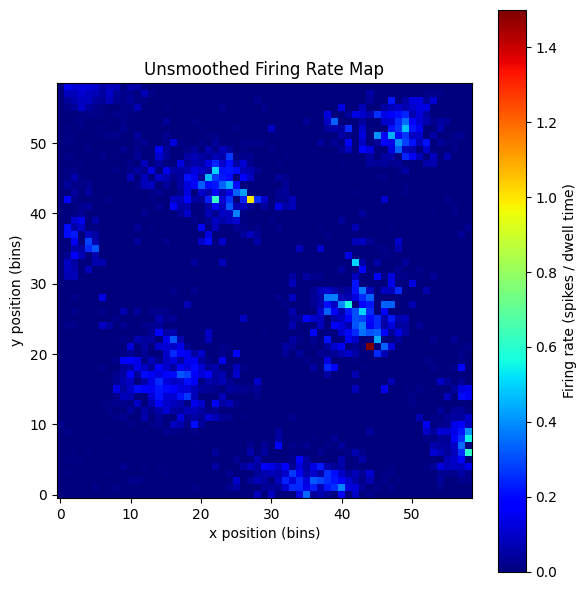

In [ ]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

grid_analysis_single_neuron.compute_firing_rate_map()

grid_analysis_single_neuron.plot_unsmoothed_rate_map()

## Smoothing the firing rate map


When we compute a firing rate map, each pixel (or bin) represents the neuron’s activity in a small spatial region of the environment.  
However the following points should be noted: 
1. The raw firing rate map can be noisy, especially in bins where the animal spent very little time or where only a few spikes occurred. This noise can make it difficult to discern the underlying spatial firing pattern. Smoothing averages the firing rate over neighboring bins, which helps to reduce this random variability and reveal the more stable firing properties of the neuron.

2. The animal may not visit every single spatial bin in the environment. Bins with zero dwell time will have an undefined firing rate (or will be set to a default value as in the compute_firing_rate_map function to avoid division by zero). Smoothing allows for the estimation of the firing rate in these unvisited or sparsely visited bins by considering the firing rates of surrounding bins.

For this reasons **smoothing** might be necessary.

The most common way to smooth spatial firing maps is by applying a **Gaussian filter**.

In simple terms, the Gaussian filter replaces each bin value with a **weighted average** of its neighbours:  
- Bins close to the center get higher weight.  
- Bins farther away get lower weight.  

The weighting follows a Gaussian (bell-shaped) function.

We use `gaussian_filter` from `scipy.ndimage` to do this easily in Python.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class GridCellAnalysis():

    def __init__(self, x, y, t, spike_times, bin_size=0.025):
        self.x = x
        self.y = y
        self.t = t
        # Since spike times is a separate data stream, 
        # adding an extra check to ensure the spike times recording for this neuron 
        # are the one related to the behavioral data relative to the previous attributes
        self.spike_times = spike_times[(spike_times >= np.min(t)) & (spike_times <= np.max(t))]
        self.bin_size = bin_size

        self._print_attributes()

    # when a function starts with "_" it means it should be used by the class itself and not the object
    def _print_attributes(self):
        print(f"x - min: {np.min(self.x)}, max: {np.max(self.x)}, shape: {self.x.shape}")
        print(f"y - min: {np.min(self.y)}, max: {np.max(self.y)}, shape: {self.y.shape}")
        print(f"t - min: {np.min(self.t)}, max: {np.max(self.t)}, shape: {self.t.shape}")
        print(f"spike_times - min: {np.min(self.spike_times)}, max: {np.max(self.spike_times)}, shape: {self.spike_times.shape}")

    def plot_trajectory(self):
        """
        Plot the 2D trajectory of the animal (x vs y).
        """
        plt.figure(figsize=(6, 6))
        plt.plot(self.x, self.y, color='k', alpha=0.6)
        plt.plot(self.x[0], self.y[0], 'go', label='start')
        plt.plot(self.x[-1], self.y[-1], 'ro', label='end')

        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.title("Animal Trajectory")
        plt.legend()
        plt.axis("equal")
        plt.show()

    def plot_spike_events(self):
        """
        Plot the spike times as an event raster.
        """
        plt.figure(figsize=(8, 3))
        plt.eventplot(self.spike_times, color="black", lineoffsets=0, linelengths=1)
        plt.xlabel("Time (s)")
        plt.title("Spike Times")
        plt.tight_layout()
        plt.show()

    def compute_firing_rate_map(self):
            
            # Compute bins using provided bin_size
            x_bins = np.arange(np.min(self.x) - self.bin_size * 0.5, np.max(self.x) + self.bin_size * 0.5, self.bin_size)
            y_bins = np.arange(np.min(self.y) - self.bin_size * 0.5, np.max(self.y) + self.bin_size * 0.5, self.bin_size)

            # Compute dwell time
            self.dwell_time, _, _ = np.histogram2d(self.x, self.y, bins=(x_bins, y_bins))

            # Compute spike counts
            self.spike_counts, _, _ = np.histogram2d(self.x[self.t.searchsorted(self.spike_times, side='right')],
                                                self.y[self.t.searchsorted(self.spike_times, side='right')],
                                                bins=(x_bins, y_bins))

            # Handle zero dwell times (avoid division by zero)
            self.dwell_time[self.dwell_time == 0] = min(self.dwell_time[self.dwell_time != 0], default=1) # Added default=1

            # Compute unsmoothed firing rate map
            self.unsmoothed_firing_rate_map = self.spike_counts / self.dwell_time

    def plot_unsmoothed_rate_map(self):
            """
            Plot the firing rate map
            """

            if self.unsmoothed_firing_rate_map is None:
                raise ValueError("You must compute the firing rate map first using compute_firing_rate_map().")

            plt.figure(figsize=(6, 6))

            im = plt.imshow(
                self.unsmoothed_firing_rate_map,
                origin='lower',
                cmap='jet',
                interpolation='nearest'
            )

            plt.title('Unsmoothed Firing Rate Map')
            plt.xlabel('x position (bins)')
            plt.ylabel('y position (bins)')
            plt.colorbar(im, label='Firing rate (spikes / dwell time)')
            plt.tight_layout()
            plt.show()

    def plot_smoothed_rate_map(self, sigma = 1.5):
        """
        Plot the firing rate map
        """

        if self.unsmoothed_firing_rate_map is None:
            raise ValueError("You must compute the firing rate map first using compute_firing_rate_map().")

        self.smoothed_firing_rate_map = gaussian_filter(self.unsmoothed_firing_rate_map, sigma)

        plt.figure(figsize=(6, 6))

        im = plt.imshow(
            self.smoothed_firing_rate_map,
            origin='lower',
            cmap='jet',
            interpolation='nearest'
        )

        plt.title('Unsmoothed Firing Rate Map')
        plt.xlabel('x position (bins)')
        plt.ylabel('y position (bins)')
        plt.colorbar(im, label='Firing rate (spikes / dwell time)')
        plt.tight_layout()
        plt.show()

x - min: -0.72621924, max: 0.7381525, shape: (339699,)
y - min: -0.72309124, max: 0.73905075, shape: (339699,)
t - min: 27826.01, max: 31222.99, shape: (339699,)
spike_times - min: 27826.754033333335, max: 31215.780933333335, shape: (6859,)


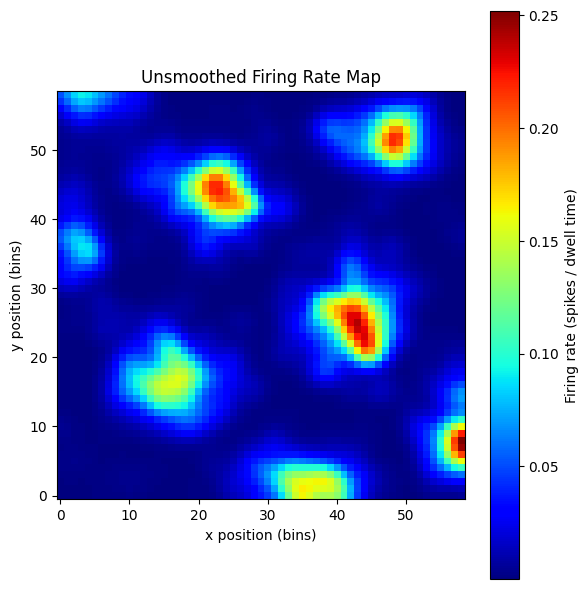

In [37]:
grid_analysis_single_neuron = GridCellAnalysis(x=x_pos, y=y_pos, t=beh_time, spike_times=spike_times)

grid_analysis_single_neuron.compute_firing_rate_map()

grid_analysis_single_neuron.plot_smoothed_rate_map()